### 観測データ
解析に必要なデータ
- XFFTS data
- encoder (doppler計算できない)
- weather status
- hosei copy
- obs copy


### 解析フロー

- doppler tracking[o]
- Chopper Wheel [o]
- baseline fitting [o]
- Scaling(from standard object?) [x]
- regrid [o]
    - rms [o]
    - distance [o]
- +header [o]
- 3d-fits[o]

In [3]:
import sys
sys.path.append("/home/amigos/git/analy_n2data/script/")
if not sys.argv[1] == "-f":
    analy_dir = sys.argv[1]
    mode = "commandline"
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    analy_dir = '/home/amigos/data/position_switching2019/n20190910070230_12CO_2-1_otf_OriKL'
    mode = "notebook"

In [4]:
!ls /home/amigos/data/position_switching2019/n20190910070230_12CO_2-1_otf_OriKL

hosei_230.txt	       ps_OriKL.obs  vobs.npy	  xffts.ndf
Position_Switch.ipynb  result_2.png  weather.csv


In [5]:
import subprocess
import os
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import numba
from astropy.io import fits
import glob
from scipy import interpolate
import time
###以下独自
import n2df
import read_obsfile
import analy_doppler_nanten

In [6]:
obspath = glob.glob(os.path.join(analy_dir, "*obs"))
obs = read_obsfile.read(obspath[0])

In [7]:
import log_weather
import numpy
###気象情報の読み込み
weather_data = log_weather.Weather_log(os.path.join(analy_dir, "weather.csv")).read()
print(weather_data)
#気象データの確認
press = numpy.mean(weather_data["press"])
humi = numpy.mean(weather_data["outhumi"])
temp = numpy.mean(weather_data["outtemp"])
lamda = 1300
print(press, humi, temp)

cabin_temp = weather_data["cabin_temp1"]

       timestamp     intemp    outtemp    inhumi   outhumi     winddir  \
0   1.568099e+09  14.740496  16.663495  1.746055  8.437842  268.509277   
1   1.568099e+09  14.810425  16.097329  1.253461  8.311794  268.074180   
2   1.568099e+09  14.811832  15.982456  1.695537  8.097386  268.863563   
3   1.568099e+09  14.837831  16.488035  1.659967  8.482275  268.134019   
4   1.568099e+09  14.928241  16.653690  1.032765  8.378077  268.141979   
5   1.568099e+09  15.313717  16.406448  1.371025  8.637743  268.399959   
6   1.568099e+09  14.961168  16.134271  1.314186  8.189721  268.061565   
7   1.568099e+09  14.519615  16.018124  1.844449  8.897255  268.820033   
8   1.568099e+09  14.434453  16.531663  1.163975  8.938106  268.670793   
9   1.568099e+09  15.088346  16.342548  1.343973  8.843993  268.731970   
10  1.568099e+09  15.194354  16.410667  1.982708  8.056381  268.379736   
11  1.568099e+09  15.309828  16.774947  1.790766  8.630956  268.593643   
12  1.568099e+09  14.693460  16.420562

In [8]:
###config 
array_num = 2#1~16IF 

### 分光データの読み出し


In [9]:
%%time
n = n2df.Read(os.path.join(analy_dir, "xffts.ndf"))
array_data = n.read_onearray(array_num)#1IFの分光データ
obs_mode = n.read_obs_mode()#観測モード（ON/OFF/HOT）
scan_num = n.read_scan_num()#スキャンライン（0,1,2,3,4,...）
###array_data, scan_num, obs_mode = n.read_for_otf(1)#3分くらいかかた
timestamp = n.read_timestamp()

100%|██████████| 1485/1485 [00:00<00:00, 351438.33it/s]

CPU times: user 28 ms, sys: 80 ms, total: 108 ms
Wall time: 125 ms


### Doppler tracking

In [109]:
obs.keys()

dict_keys(['offset_Az', 'offset_El', 'lambda_on', 'beta_on', 'lambda_off', 'beta_off', 'coordsys', 'object', 'vlsr', 'tuning_vlsr', 'cosydel', 'lamdel', 'betdel', 'otadel', 'lamdel_off', 'betdel_off', 'otadel_off', 'acc', 'observer', 'obsmode', 'purpose', 'tsys', 'nSeq', 'nON', 'exposure', 'exposure_off', 'load_interval', 'cold_flag', 'pllref_if', 'multiple', 'pllharmonic', 'pllsideband', 'pllreffreq', 'restfreq_1', 'obsfreq_1', 'molecule_1', 'transiti_1', 'lo1st_sb_1', 'if1st_freq_1', 'lo2nd_sb_1', 'lo3rd_sb_1', 'lo3rd_freq_1', 'if3rd_freq_1', 'start_ch_1', 'end_ch_1', 'restfreq_2', 'obsfreq_2', 'molecule_2', 'transiti_2', 'lo1st_sb_2', 'if1st_freq_2', 'lo2nd_sb_2', 'lo3rd_sb_2', 'lo3rd_freq_2', 'if3rd_freq_2', 'start_ch_2', 'end_ch_2', 'fpga_integtime'])

In [10]:
on_x = obs["lambda_on"]
on_y = obs["beta_on"]
off_x = obs["lambda_off"]
off_y = obs["beta_off"]

In [11]:
d = analy_doppler_nanten.doppler_nanten()
from numpy import deg2rad
if not os.path.exists(os.path.join(analy_dir, "vobs.npy")):
    vobs = []
    for i in range(len(array_data)):
        if obs_mode[i] == "ON":
            vobs.append(d.calc_vobs(deg2rad(on_x), deg2rad(on_y), timestamp[i]))
        elif obs_mode[i] == "OFF" or obs_mode[i] == "HOT":
            vobs.append(d.calc_vobs(deg2rad(off_x), deg2rad(off_y), timestamp[i]))
    numpy.save(os.path.join(analy_dir, "vobs"), vobs)
else:
    print(" vobs.npy already exists")

 vobs.npy already exists


In [12]:
vobs = numpy.load(os.path.join(analy_dir, "vobs.npy"))

# For debug
if numpy.count_nonzero(vobs>0) == len(vobs):
    print("vobsは全て正")
elif numpy.count_nonzero(vobs<0) == len(vobs):
    print("vobsは全て負")
else:
    print("vobsは正も負もある")

# config
dv = 0.167#km/s
ch = numpy.linspace(0, 32767, 32768)
bch = list(map(int, vobs//dv))#ch数の移動
slide_ch = (vobs/dv) - bch#interpolationによる移動量

dp_data = []
xx_data = []
for i in tqdm(range(len(vobs))):
    f = interpolate.interp1d(ch, array_data[i])
    ch2 = ch+slide_ch[i]
    if slide_ch[i] > 0:
        n = f(ch2[:-1])
    elif slide_ch[i] <0:
        n = f(ch2[1:])
    new_p = n
    xx = ch[:-1] - bch[i]
    yy = new_p
    xx_data.append(xx)
    dp_data.append(yy)
    
xx_data = numpy.array(xx_data)
xx_min = numpy.max(xx_data.T[0])#regridの最小値
xx_max = numpy.min(xx_data.T[-1])#regirdの最大値

new_xx = numpy.arange(xx_min, xx_max+1, 1)
print(new_xx, len(new_xx))
vlen = len(new_xx)

mask_list= []
for i in range(len(xx_data)):
    mask = (xx_data[i] >= xx_min) & (xx_data[i] <= xx_max)
    mask_list.append(mask)
    
new_yy_list = []
for i in tqdm(range(len(xx_data))):
    new_yy_list.append(dp_data[i][mask_list[i]])
    
len(new_xx)
origin_array_data = array_data
array_data = new_yy_list
numpy.shape(array_data)

  2%|▏         | 29/1485 [00:00<00:05, 282.70it/s]

vobsは全て正


 72%|███████▏  | 1074/1485 [00:00<00:00, 10739.91it/s]

[  -48.   -47.   -46. ... 32716. 32717. 32718.] 32767


100%|██████████| 1485/1485 [00:00<00:00, 9756.46it/s] 


(1485, 32767)

In [13]:
###index探し
obs_mode = numpy.array(obs_mode)
scan_num = numpy.array(scan_num)

offmask = obs_mode == "OFF"
offindex = numpy.where(offmask == True)

hotmask = obs_mode == "HOT"
hotindex = numpy.where(hotmask == True)

onmask = obs_mode == "ON"
onindex = numpy.where(onmask == True)

max_scannum = numpy.max(scan_num)#Caution! scan num starts from 0, so scan number of 26 indicates 27 times scan

### hot/offの積分

In [14]:
#HOT積分
print(numpy.unique(scan_num[hotindex[0]]))#HOT のscan number
hotnum = numpy.unique(scan_num[hotindex[0]])#HOTの数

hotdata = []

for i in tqdm(hotnum):#i = scan number
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], hotindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]
    ###
    mm = index[0][c]#scan numの値でフィルターしたhot
    #print(mm)
    ###積分
    tmp = [array_data[j] for j in mm]
    hotdata.append(sum(tmp)/len(tmp))
    pass

#下は擬似データの質が低いための処理。将来的に削除
#hotdata = numpy.array(hotdata)
#hotdata = hotdata + 5000

100%|██████████| 6/6 [00:00<00:00, 324.32it/s]

[0 1 2 3 4 5]


In [15]:
##OFFの積分
print(numpy.unique(scan_num[offindex[0]]))#HOT のscan number
offnum = numpy.unique(scan_num[offindex[0]])#HOTの数

offdata = []
scan_num = numpy.array(scan_num)

for i in tqdm(offnum):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], offindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    offdata.append(sum(tmp)/len(tmp))

100%|██████████| 5/5 [00:00<00:00, 292.61it/s]

[0 1 2 3 4]


In [16]:
##ONの積分
print(numpy.unique(scan_num[onindex[0]]))#HOT のscan number
on_num = numpy.unique(scan_num[onindex[0]])#HOTの数

ondata = []
scan_num = numpy.array(scan_num)

for i in tqdm(on_num):
    mask = scan_num == i#特定のscannumのindexを抜き出す
    index = numpy.where(mask == True)#特定のscannumのindex変数
   ### 
    c = numpy.in1d(index[0], onindex[0])#特定のscannumのindex&HOT index
    c = numpy.where(c == True)[0]#scannumとhotで絞ったindex
    mm = index[0][c]#scan numの値でフィルターしたhot
    tmp = [array_data[j] for j in mm]
    ondata.append(sum(tmp)/len(tmp))

100%|██████████| 5/5 [00:00<00:00, 271.56it/s]

[0 1 2 3 4]


In [17]:
# ###Choper wheel
@numba.jit
def chopper_wheel(on, off, hot, temprature = 300):
    Tastar = temprature * (on - off)/(hot - off)
    return Tastar

In [18]:
chdata = [chopper_wheel(ondata[i], offdata[i], hotdata[i]) for i in range(len(ondata))]

## Baseline fitting

In [19]:
#baseline fitting parameter
center = 8000
width = 1000
start = 3000
end = 30000

#baseline fitting function
def f(x, a, b, c):
    return a*x**2 + b*x + c

def  baseline_fitting(arr_x, arr_y, index1, index2, index3, index4):
    tmpdata_y1 = arr_y[index1:index2]
    tmpdata_y2 = arr_y[index3:index4]
    tmpdata_x1 = arr_x[index1:index2]
    tmpdata_x2 = arr_x[index3:index4]
    x = numpy.concatenate([tmpdata_x1, tmpdata_x2])
    y = numpy.concatenate([tmpdata_y1, tmpdata_y2])
    param = numpy.polyfit(x, y, 2)
    arr_y = arr_y - f(arr_x, *param)
    return arr_y
    
#ch
xindex = numpy.linspace(0, vlen, vlen)

#baseline fitting index
index1 = int(start)
index2 = int(center - width/2)
index3 = int(center + width/2)
index4 = int(end)
print(index1, index2, index3, index4)

testoffset = numpy.linspace(1, vlen, vlen)

for i in tqdm(range(len(chdata))):
    chdata[i] = chdata[i] + testoffset#ベースラインフィッティングできているかの確認のため
    origin = chdata[i]#for debug, this will be deleted
    chdata[i] = baseline_fitting(xindex, chdata[i], index1, index2, index3, index4)
    
    
#plt.plot(chdata[i], label="after chopper wheel")#after chopper wheel
#plt.plot(origin, label="before chopper wheel")#before chopper wheel
#plt.legend()
#plt.grid()

100%|██████████| 5/5 [00:00<00:00, 216.55it/s]

3000 7500 8500 30000


In [20]:
#Vlsrの計算
vlsr = (new_xx - 16384)*dv

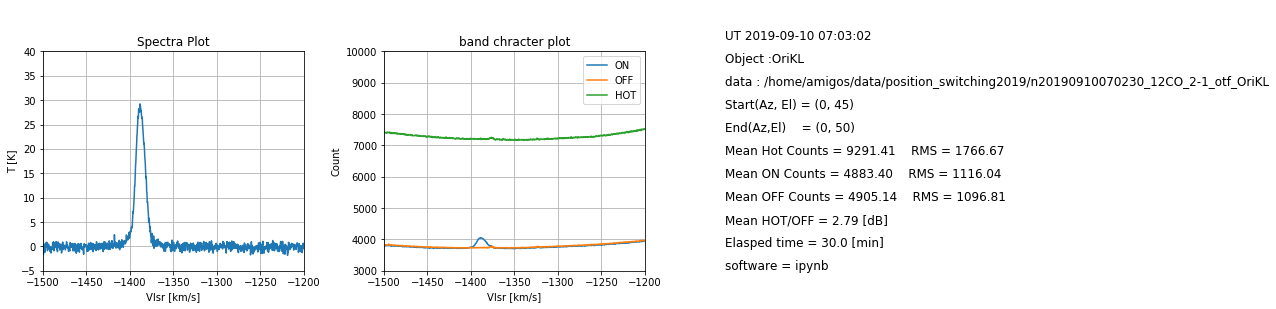

In [146]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(vlsr, chdata[0])
ax[0].set_xlim(-1500, -1200)
ax[0].set_ylim(-5, 40)
ax[0].grid(True)
ax[0].set_xlabel("Vlsr [km/s]")
ax[0].set_ylabel("T [K]")
ax[0].set_title("Spectra Plot")

ax[1].plot(vlsr, ondata[0], label="ON")
ax[1].plot(vlsr, offdata[0], label="OFF")
ax[1].plot(vlsr, hotdata[0], label="HOT")
ax[1].set_xlim(-1500, -1200)
ax[1].set_ylim(3000,10000)
ax[1].set_xlabel("Vlsr [km/s]")
ax[1].set_ylabel("Count")
ax[1].grid(True)
ax[1].legend()
ax[1].set_title("band chracter plot")

ax[2].set_axis_off()
ax[2].invert_yaxis()
template = """
UT {start_time}
Object :{obs[object]}
data : {analy_dir}
Start(Az, El) = (0, 45)
End(Az,El)    = (0, 50)
Mean Hot Counts = {mean_hot:.2f}    RMS = {rms_hot:.2f}
Mean ON Counts = {mean_on:.2f}    RMS = {rms_on:.2f}
Mean OFF Counts = {mean_off:.2f}    RMS = {rms_off:.2f}
Mean HOT/OFF = {yfactor:.2f} [dB]
Elasped time = 30.0 [min]
software = ipynb
"""
from datetime import datetime
d = datetime.utcfromtimestamp(timestamp[0])
start_time = d.strftime("%Y-%m-%d %H:%M:%S")
mean_hot = numpy.mean(hotdata[0])
mean_off = numpy.mean(offdata[0])
mean_on = numpy.mean(ondata[0])
# rms_hot = numpy.sqrt(numpy.square(hotdata[0]**2))
# rms_off = numpy.sqrt(numpy.mean(offdata[0]**2))
# rms_on = numpy.sqrt(numpy.mean(ondata[0]**2))
rms_hot = numpy.std(hotdata[0])
rms_off = numpy.std(offdata[0])
rms_on = numpy.std(ondata[0])
yfactor = 10*numpy.log10(numpy.mean(hotdata[0]/offdata[0]))
ax[2].text(0, 1.1, template.format(**locals()), linespacing=2, fontsize=12)

plt.tight_layout()
plt.show()

### astropyでfitsに書き出す

ヘッダーの作成